In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt

In [3]:
n_docs = 127 #quixote docs
n_topics = 20

gut_n_docs = 3036

In [4]:
#an array containing all corpus text titles
titles = []
with open("titles.txt", "r") as inf:
    for line in inf:
        titles = line.split("/")
        
#an array containing indexes in biggie.txt (corpus) at which each text starts
title_idxs = []
with open("title_starts.txt", "r") as inf:
    for line in inf:
        title_idxs = [int(i) for i in line.split(",")]

#word counts for each line (100-500 word segment) of biggie.txt (corpus)
word_counts = []
with open("gut_wordcounts.txt", "r") as inf:
        for line in inf:
            word_counts = [int(i) for i in line.split(",")]
 
print(len(word_counts))
print(len(titles))
print(len(title_idxs))
#ok the above are good

879536
3036
3036


In [5]:
#a matrix where each row is the average topic composition of a text in the corpus
gut_doc_topics = np.zeros((gut_n_docs, n_topics))
all_props= []
with open("biggie_doc-topics.txt", "r") as comp:
    all_props = comp.readlines()
    for i, idx in enumerate(title_idxs):
        if i == len(title_idxs)-1:
            end_idx = 879536
        else: end_idx = title_idxs[i+1]
        
        #weight each segment's proportions by the word count, add all segments, and divide by summed word count
        sums = np.zeros(n_topics)
        for x in range(idx, end_idx):
            arr = [float(y) for y in all_props[x].split()[2:]]
            weighted = np.array(arr) * word_counts[x]
            sums += weighted
        sums /= sum(word_counts[idx:end_idx])
        gut_doc_topics[i,:] = sums

In [6]:
# using the above, it should be easy enough to find the average composition of quixote; 
# gut_doc_topics[-1] (since quixote is the last doc in the corpus). 
# however, this topic composition is very different from the one I find when inferring 
# topics from the text outside of the corpus.

# I wasn't able to figure out how to solve this discrepency and ended up going with the 
# inferred compositions.

In [7]:
#average topic composition of entire corpus
avg_topics = gut_doc_topics.sum(axis=0)/gut_n_docs
print(avg_topics)

#average topic composition of DQ
#avg_dq_topics = gut_doc_topics[-1]
#print(avg_dq_topics)

[0.08504297 0.052498   0.06058977 0.06914445 0.08965924 0.03848585
 0.0272426  0.07583658 0.02673435 0.03112514 0.02559525 0.0340089
 0.05994299 0.02051714 0.08540283 0.06181611 0.03343451 0.01437705
 0.05078981 0.05775646]


In [8]:
# avg DQ topic composition based on topic inference (model inferencer) of DQ 
quixote_linecount = 1789 
dq_topics = np.zeros((quixote_linecount, n_topics)) #topics per 100-500 word segment
with open("gut_dq_topics.txt", "r") as comp:
    next(comp) 
    for i, line in enumerate(comp):
        newl = line.split()
        dq_topics[i] = newl[2:]

seg_wordcounts = np.zeros(quixote_linecount)
with open("split_quixote.txt", "r") as inf:
    for i, line in enumerate(inf):
        wc = len(line.split("\t")[2].split(" "))
        seg_wordcounts[i] = int(wc)

mult_wc = np.zeros((quixote_linecount,n_topics))
for k, wc in enumerate(seg_wordcounts):
    mult_wc[k] = dq_topics[k] * wc
        
avg_dq_topics = mult_wc.sum(axis=0)/sum(seg_wordcounts)
print(avg_dq_topics)
print(sum(avg_dq_topics))

[0.08128525 0.01482331 0.04821054 0.07654149 0.21012425 0.00822577
 0.02417611 0.09562245 0.00428452 0.01112066 0.03147866 0.04940055
 0.01514459 0.01128002 0.17533182 0.04102184 0.01037824 0.00425767
 0.07186573 0.01542654]
0.9999999999999997


In [9]:
gut_keys =[]
full_gut_keys =[]
#topic labels
with open("gut_keys.txt", "r") as f:
    for line in f:
        keys = line.split("\t")[2].split(" ")
        full_gut_keys.append(" ".join(keys[:-1]))
#topic keywords (out to 20th top word)
with open("gut_topic_labels.txt", "r") as f:
    for line in f:
        key = line.strip()
        gut_keys.append(key)

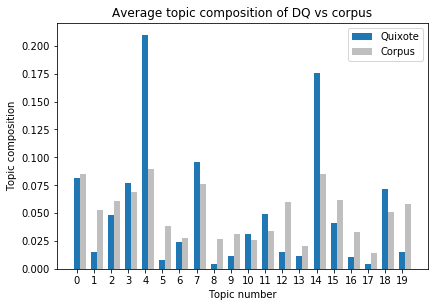

In [10]:
#bar graph of average topic composition of DQ and avg topic composition of the corpus

fig,ax = plt.subplots()
bar_width = 0.35

plt.bar(np.arange(n_topics), avg_dq_topics, bar_width, label="Quixote")
plt.bar(np.arange(n_topics)+bar_width, avg_topics, bar_width, color="grey", alpha=0.5, label="Corpus")
plt.xticks(np.arange(n_topics), np.arange(n_topics))
plt.legend()
plt.tight_layout()
ax.set(title = "Average topic composition of DQ vs corpus", xlabel = "Topic number", \
       ylabel = "Topic composition")
plt.show()

In [11]:
#bigger compared to corp (according to avgd chapters) = 4, 14
#smaller compared to corp : 1 5 8 9 12 16 19
#8 being low is very surprising to me...

In [12]:
#topics out to the 20th keyword
for i, topic in enumerate(full_gut_keys):
    print(str(i)+". " + topic)

#my labels for each
print("\nLabels")
for i, topic in enumerate(gut_keys):
    print(str(i)+". " + topic)

0. man life men world things great nature human mind work thing true sense good fact time people knowledge make art
1. mrs mother dont miss good dear thought home poor father girl time child young make made children boy day aunt
2. dont man ill boys good back tom aint time didnt ive hes asked sam boy make dick replied put youre
3. sun day light long night air trees green sea sky white wind great dark water blue earth high river deep
4. time made life young man mind thought found day good friend felt manner great long make friends father part present
5. lady mrs sir miss man lord dont house young dear made good thought told letter make wife father time knew
6. letters works book read volume letter footnote written lord english author books vol poems byron poet wrote life published story
7. good day man time house work made money people morning place put make night found great street town days home
8. sir king lord prince lady duke queen man good knight young english castle master great 

In [13]:
#low-pass filter for plots
# Copied from https://tomroelandts.com/articles/how-to-create-a-simple-low-pass-filter
fc = 0.05  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
b = 0.2  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
N = int(np.ceil((4 / b)))
if not N % 2: N += 1  # Make sure that N is odd.
n = np.arange(N)
 
# Compute sinc filter.
h = np.sinc(2 * fc * (n - (N - 1) / 2))
 
# Compute Blackman window.
w = np.blackman(N)
 
# Multiply sinc filter with window.
h = h * w
 
# Normalize to get unity gain.
h = h / np.sum(h)

#another source on this but less good : https://gist.github.com/junzis/e06eca03747fc194e322

delay = (len(h)-1)/2 #determined from comments on above source

NameError: name 'gut_in_dq_topics' is not defined

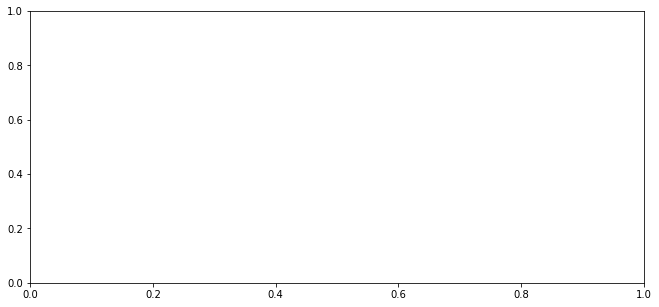

In [14]:
#topics split into 2 graphs because pyplot only has 10 colors

fig = plt.figure(figsize=(11,5))
ax = plt.subplot()
for x in range(10):
    data = gut_in_dq_topics[:,x]
    filtered_data = np.convolve(data, h)
    ax.plot(np.arange(len(filtered_data))-delay, filtered_data, label= str(x) + " " + gut_keys[x])
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6,chartBox.height])
ax.legend(loc='upper right', bbox_to_anchor=(1.7, 1.05), title="Topics 0-9",\
          shadow=True, ncol=1)
ax.set(title = "Topic compositions across all DQ chapters, for topics 0-9",\
       xlabel = "Chapter number", ylabel = "Topic composition")

fig = plt.figure(figsize=(11,5))
ax = plt.subplot()
for x in range(10):
    data = gut_in_dq_topics[:,x+10]
    filtered_data = np.convolve(data, h)
    ax.plot(np.arange(len(filtered_data))-delay, filtered_data, label= str(x+10) + " " + gut_keys[x+10])
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.6, chartBox.height])
ax.legend(loc='upper right', bbox_to_anchor=(1.85, 1.05), title="Topics 10-19", shadow=True, ncol=1)
ax.set(title = "Topic compositions across all DQ chapters, for topics 10-19", xlabel = "Chapter number", \
       ylabel = "Topic composition")
plt.show()

In [ ]:
#gut topics over time in gut isn't very informative

In [ ]:
#quixote chapters with the top 10 highest compositions of topic 4
with open("chapters_dq.txt", "r") as inf:
    ff = inf.readlines()
    for x in np.argpartition(gut_in_dq_topics[:,4], n_docs-10)[-10:]: # argpartition splits input array into segments
        #accordting to second argument, and those after the split are greater than those before, according to the
        # first arg
        print(gut_in_dq_topics[x,4])
        #print(ff[x])

In [38]:
#titles of corpus texts with the top 10 highest compositions of topic 4
gut_indeces_4 = []
for x in np.argpartition(gut_doc_topics[:,4], n_docs-10)[-10:]: # argpartition splits input array into segments
    #accordting to second argument, and sorts all that come after the split i think.
    gut_indeces_4.append(x)
    print(x, titles[x])
print(gut_indeces_4)
print(gut_doc_topics[gut_indeces_4, 4])

57 Sir Walter Scott___My Aunt Margaret's Mirror
54 Sir Walter Scott___The Antiquary, Complete
23 Sir Walter Scott___Guy Mannering
3029 Nathaniel Hawthorne___The Seven Vagabonds (From "Twice Told Tales")
20 Robert Louis Stevenson___The Works of Robert Louis Stevenson - Swanston Edition, Volume 5
15 Louisa May Alcott___Behind A Mask, Or A Woman's Power
3032 Bret Harte___Found At Blazing Star
3033 Jane Austen___Pride and Prejudice
4 Herman Melville___The Piazza Tales
0 Bret Harte___A Ward of the Golden Gate
[57, 54, 23, 3029, 20, 15, 3032, 3033, 4, 0]
[0.41617765 0.20493616 0.24716508 0.27354358 0.20358453 0.20383022
 0.19077644 0.48606325 0.20969423 0.25783586]


In [39]:
#quixote chapters with the top 10 highest compositions of topic 14
with open("../dq_prep/chapters_dq.txt", "r") as inf:
    ff = inf.readlines()
    for x in np.argpartition(gut_in_dq_topics[:,14], n_docs-10)[-10:]: # argpartition splits input array into segments
        #accordting to second argument, and sorts all that come after the split i think.
        print(gut_in_dq_topics[x,14])
        print(ff[x])
print(gut_indeces_14)
print(gut_doc_topics[gut_indeces_14, 14])

0.2277689747335864
5	CHAPTER V	CHAPTER V  IN WHICH THE NARRATIVE OF OUR KNIGHTS MISHAP IS CONTINUED Finding then that in fact he could not move he thought himself of having recourse to his usual remedy which was to think of some passage in his books and his craze brought to his mind that about Baldwin and the Marquis of Mantua when Carloto left him wounded on the mountain side a story known by heart by the children not forgotten by the young men and lauded and even believed by the old folk and for all that not a whit truer than the miracles of Mahomet  This seemed to him to fit exactly the case in which he found himself so making a show of severe suffering he began to roll on the ground and with feeble breath repeat the very words which the wounded knight of the wood is said to have uttered Where art thou lady mine that thou My sorrow dost not rue Thou canst not know it lady mine Or else thou art untrue  And so he went on with the ballad as far as the lines O noble Marquis of Mantua My

NameError: name 'gut_indeces_14' is not defined

In [40]:
#titles of corpus texts with the top 10 highest compositions of topic 14
gut_indeces_14 = []
for x in np.argpartition(gut_doc_topics[:,14], n_docs-10)[-10:]: # argpartition splits input array into segments
    #accordting to second argument, and sorts all that come after the split i think.
    gut_indeces_14.append(x)
    print(x, titles[x])
print(gut_indeces_14)
print(gut_doc_topics[gut_indeces_14, 14])

7 Thomas Hardy___Late Lyrics and Earlier
3027 Rudyard Kipling___Captains Courageous
3028 Jack London___The Sea-Wolf
3029 Nathaniel Hawthorne___The Seven Vagabonds (From "Twice Told Tales")
5 Andrew Lang___A Monk of Fife
4 Herman Melville___The Piazza Tales
3032 Bret Harte___Found At Blazing Star
3 John Galsworthy___Loyalties
3034 Harriet Elizabeth Beecher Stowe___Uncle Tom's Cabin
0 Bret Harte___A Ward of the Golden Gate
[7, 3027, 3028, 3029, 5, 4, 3032, 3, 3034, 0]
[0.07553653 0.06584449 0.1835129  0.08943884 0.07355482 0.130796
 0.33094833 0.12471348 0.10503128 0.24858775]


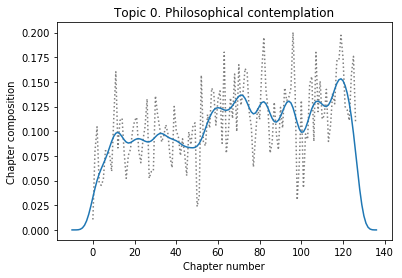

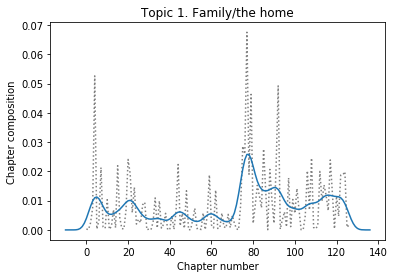

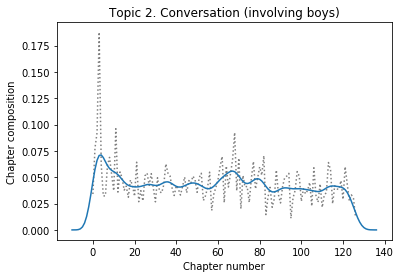

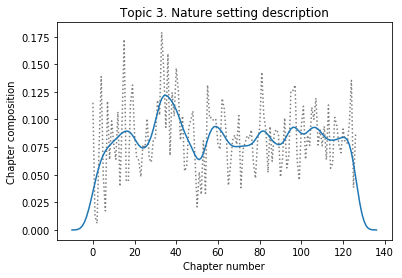

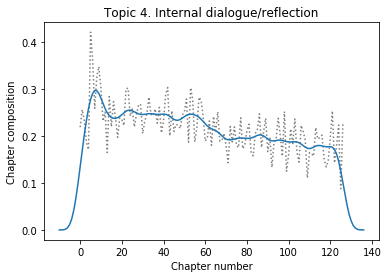

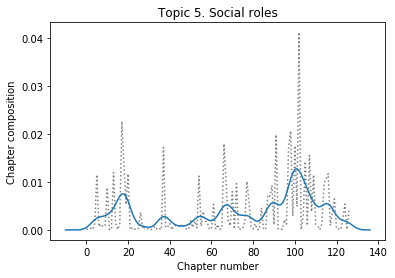

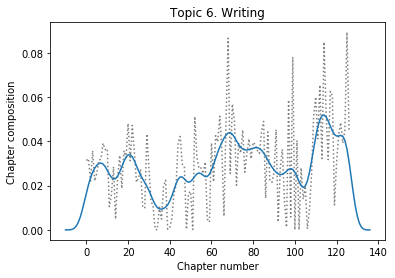

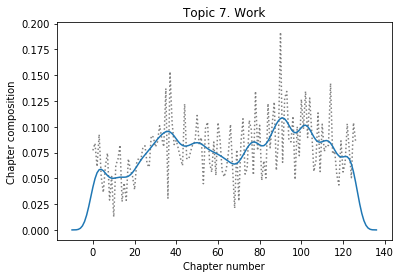

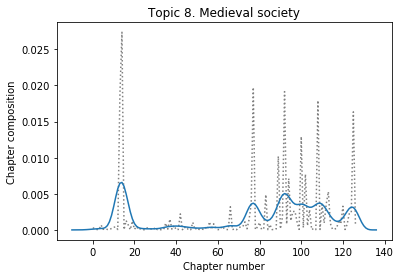

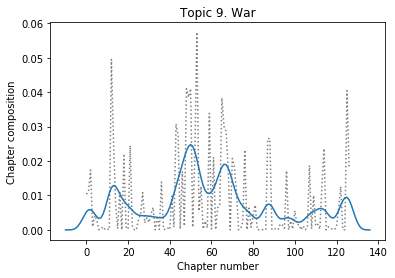

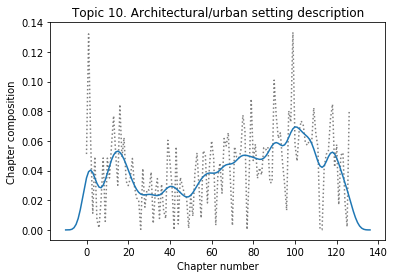

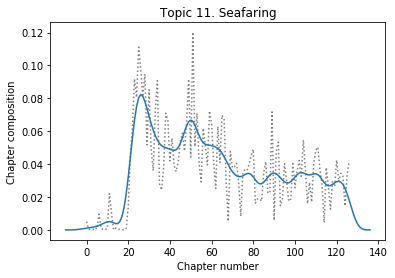

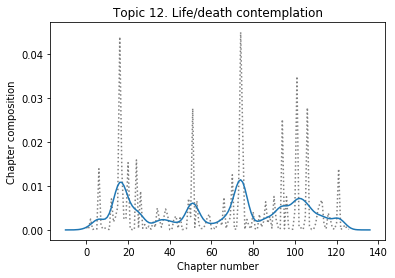

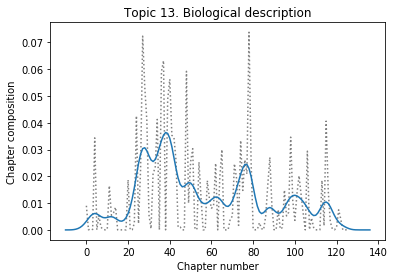

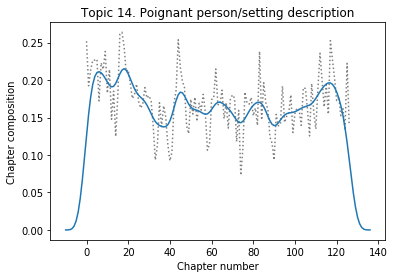

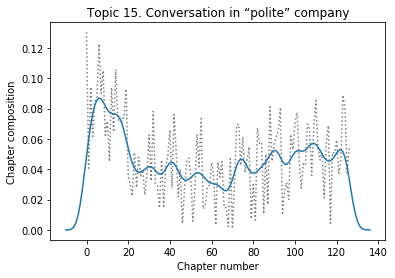

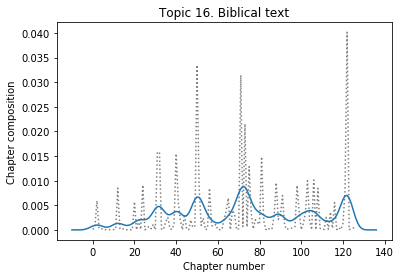

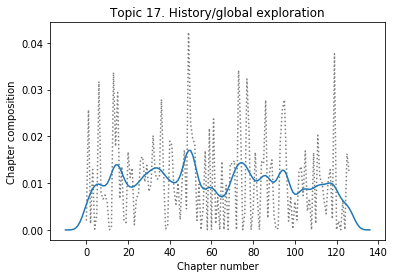

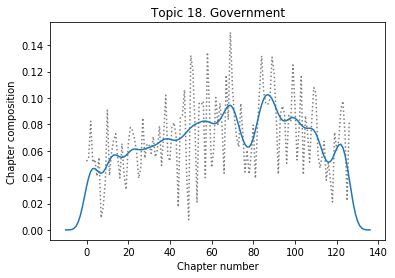

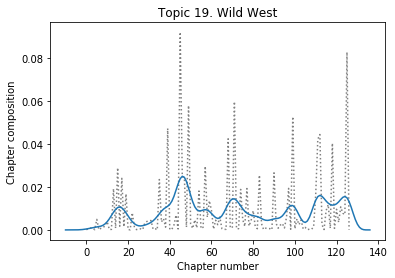

In [41]:
#corpus topics over time (chapters) in DQ
for x in range(n_topics):
    data = gut_in_dq_topics[:,x]
    filtered_data = np.convolve(data, h)
    fig, ax=plt.subplots()
    ax.plot(np.arange(n_docs), data, c="grey", ls=":")
    ax.plot(np.arange(len(filtered_data))-delay, filtered_data)
    ax.set(title = "Topic " + str(x) + ". " + gut_keys[x], xlabel = "Chapter number", ylabel = "Chapter composition")
    plt.show()